In [1]:
import os
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D


dataset_path = "data"
image_size = (64*5, 48*5)

dataset_path = "data"

print('Our dataset = ')
print(os.listdir(dataset_path))

Our dataset = 
['Grupo_0', 'Grupo_1', '.DS_Store', 'Grupo_4', 'Grupo_3', 'Grupo_2', 'Grupo_5']


Step 1: Loading DataSet

In [2]:
def load_images_from_folder(folder_path, max_depth = 5):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    for root, dirs, files in os.walk(folder_path):
        current_depth = root[len(folder_path):].count(os.sep)

        if ('IriTech' in root) or ('Iritech' in root) or ('iriTech' in root) or ('iritech' in root):
            continue
        

        if current_depth <= max_depth:
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    img_path = os.path.join(root, file)
                    try:
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, image_size)
                            images.append(img)
                            labels.append(file[6]!='0')
                            names.append(file)
                    except:
                        corruptedFiles.append(img_path)

        else:
            del dirs[:]
    
    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")

    return np.array(images), np.array(labels), np.array(names)

images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the data folder with shape {images.shape}")

Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the data folder with shape (2820, 240, 320)


(240, 320)


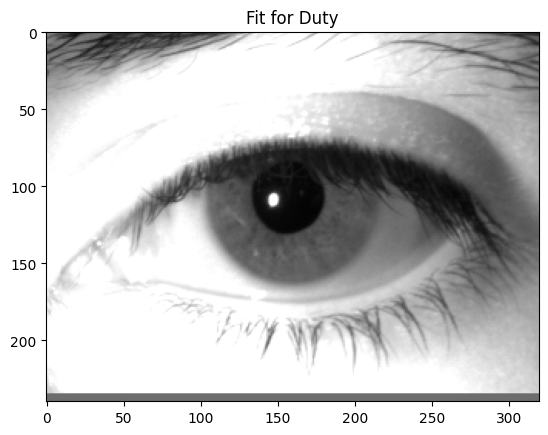

In [3]:
def showImg(index):
    plt.imshow(images[index], cmap='gray')
    plt.title('Alcoholic' if labels[index] else 'Fit for Duty')
    print(images[index].shape)

showImg(900)

In [4]:
#Removing Bias towards Alcohol Detection

#Splitting Classes
alcoholicClass = [images[i] for i in range(len(labels)) if labels[i] == 1]
nonAlcoholicClass = [images[i] for i in range(len(labels)) if labels[i] == 0]

alcoholicClass = np.array(alcoholicClass)
nonAlcoholicClass = np.array(nonAlcoholicClass)

#Data Generator Setup
datagen = ImageDataGenerator(
    rotation_range=4,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.025,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Augmentation:

n1 = len(nonAlcoholicClass)
n2 = len(alcoholicClass)
target_size = n2
augmentation_needed = target_size - n1

print(f'Number of samples in Class 1 (FFD): {n1}')
print(f'Number of samples in Class 2 (Alcoholic): {n2}')
print(f'Augmenting {augmentation_needed} images for Class 1 to match Class 2.')

augmented_images = []
for i in range(augmentation_needed):
    img = nonAlcoholicClass[i % n1]  
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)  
    augmented_img = next(datagen.flow(img, batch_size=1))[0]
    augmented_img = np.squeeze(augmented_img, axis=-1)
    augmented_img = augmented_img.astype(int)
    augmented_images.append(augmented_img)

augmented_images = np.array(augmented_images)

concagtedClassNon = np.concatenate([nonAlcoholicClass, augmented_images], axis=0)
concagtedClassNon = np.concatenate([nonAlcoholicClass, augmented_images], axis=0)

print(f'New size of Class 1: {len(alcoholicClass)}')
print(f'New size of Class 2: {len(concagtedClassNon)}')

Number of samples in Class 1 (FFD): 580
Number of samples in Class 2 (Alcoholic): 2240
Augmenting 1660 images for Class 1 to match Class 2.
New size of Class 1: 2240
New size of Class 2: 2240


In [9]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.7, random_state=23)

labels_train_cnn = to_categorical(labels_train, num_classes=2)
labels_test_cnn = to_categorical(labels_test, num_classes=2)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=image_size+(1,)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(images_train, labels_train_cnn, epochs=10, batch_size=32)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 479ms/step - accuracy: 0.6457 - loss: 1141.1304
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 424ms/step - accuracy: 0.7828 - loss: 0.8613
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 414ms/step - accuracy: 0.7937 - loss: 0.4871
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 407ms/step - accuracy: 0.8121 - loss: 0.4313
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 413ms/step - accuracy: 0.8319 - loss: 0.3728
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 430ms/step - accuracy: 0.8535 - loss: 0.3651
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step - accuracy: 0.8320 - loss: 0.4034
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 411ms/step - accuracy: 0.8515 - loss: 0.4375
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 411ms/step - accuracy: 0.8565 - loss: 0.3739
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step - accuracy: 0.8511 - loss: 0.3504


In [10]:
#Testing model
cnn_loss, cnn_accuracy = cnn_model.evaluate(images_test, labels_test_cnn)
print(f"CNN Test Accuracy: {cnn_accuracy * 100:.2f}%")

predictions = cnn_model.predict(images_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test_cnn, axis=1)

report = classification_report(true_classes, predicted_classes, target_names=['Fit for Duty', 'Alcoholic'])
print(report)

accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Overall Accuracy: {accuracy * 100:.2f}%')

62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.7549 - loss: 0.6367
CNN Test Accuracy: 75.03%
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step
              precision    recall  f1-score   support

Fit for Duty       0.25      0.11      0.15       404
   Alcoholic       0.80      0.91      0.85      1570

    accuracy                           0.75      1974
   macro avg       0.53      0.51      0.50      1974
weighted avg       0.69      0.75      0.71      1974

Overall Accuracy: 75.03%


Demonstration

In [7]:
totalTest = 0
correctTest = 0

(1, 240, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Text(0.5, 1.0, 'Name: E_5_0_2_L_M_N_N_1992_9_2017.bmp\n\nPrediction: Alcoholic\nActual: Alcoholic\n\nAccuracy: 1.0')

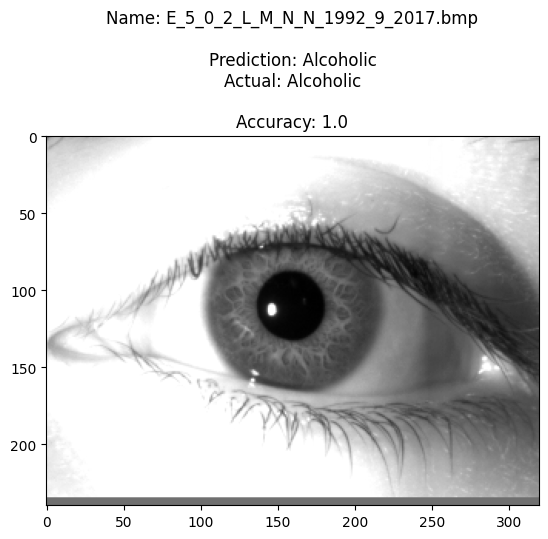

In [8]:
# testImagePath = 'data/Grupo_5/E_5_7/Iritech/E_5_7_0/E_5_7_0_L_F_N_N_1994_0_2017.bmp'
# testImg = cv2.imread(testImagePath, cv2.IMREAD_GRAYSCALE)

r_in = random.randint(0, len(images) - 1)


testImg = images[r_in]
testLabel = labels[r_in]
testImg = cv2.resize(testImg, image_size)

plt.imshow(testImg, cmap='gray')

testImg = np.expand_dims(testImg, axis=0)

print(testImg.shape)

prediction = cnn_model.predict(testImg)
prediction = np.argmax(prediction[0])

totalTest +=1
correctTest += prediction==testLabel

prediction = 'Alcoholic' if prediction else 'Fit for duty'
testLabel = 'Alcoholic' if testLabel else 'Fit for duty'
plt.title(f'Name: {names[r_in]}\n\nPrediction: {prediction}\nActual: {testLabel}\n\nAccuracy: {correctTest/totalTest}')